In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.autonotebook import tqdm
import sklearn, sklearn.metrics

import glob
import captum
import latentshift
import classifiers
import ct_models
import ct_datasets
import skimage

/tmp/ipykernel_35471/958535668.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
device = 'cuda'

In [4]:
model = classifiers.phecode2.PheCodeClassifier().to(device)

Some weights of LongformerModel were not initialized from the model checkpoint at yikuan8/Clinical-Longformer and are newly initialized: ['longformer.pooler.dense.bias', 'longformer.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
weights_path = '/home/groups/akshaysc/joecohen/weights/'
#ae_folder = '2023-07-27T19-35-51_ct_vqgan_sdd'
ae_folder = '2023-12-25T10-26-40_ct2_vqgan256_sddd'
ae = ct_models.VQGAN(
    ckpt_path=f'{weights_path}/{ae_folder}/checkpoints/last.ckpt',
    yaml_path=glob.glob(f'{weights_path}/{ae_folder}/configs/*-project.yaml')[0],
    resize=256,
).to(device)

Working with z of shape (1, 256, 4, 4) = 4096 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [6]:
#!ls /home/users/joecohen/group/phecode_scans/pacemaker/

In [7]:
# data = ct_datasets.NIFTI_Dataset('/home/users/joecohen/group/', 
#                                 resolution=224)

In [8]:
data = ct_datasets.NIFTI_Dataset('/home/users/joecohen/group/phecode_scans/pacemaker//', 
                                resolution=224)

In [9]:
# data = ct_datasets.NIFTI_Dataset('/home/users/joecohen/oak/cts/LUNG', 
#                                 resolution=224)

In [10]:
len(data)

10

In [23]:
img = data[1]['image'][None,...]
img.shape

torch.Size([1, 1, 224, 224, 174])

In [21]:
data[1]['image_path']

'/home/users/joecohen/group/phecode_scans/pacemaker/AC424343e_0000.nii.gz'

In [13]:
img.min(), img.max()

(metatensor(0.), metatensor(1.))

In [19]:
for i in range(10):
    sample = data[i]
    img = sample['image'][None,...]
    with torch.no_grad():
        o = model(img.cuda()).cpu()
    print(i, os.path.basename(sample['image_path']))

    for ind, target in [(i, target) for i, target in enumerate(model.targets) if 'megaly' in target]:
        print("   " + str(float(o[:,ind])) + "  " + model.targets[ind])

0 AC42409a7_0000.nii.gz
   0.00021270128490868956  Acromegaly and gigantism
   0.5516435503959656  Cardiomegaly
   0.06055539473891258  Hepatomegaly
   0.015501954592764378  Splenomegaly
1 AC424343e_0000.nii.gz
   0.0001273562083952129  Acromegaly and gigantism
   0.7522868514060974  Cardiomegaly
   0.1241414025425911  Hepatomegaly
   0.5706890225410461  Splenomegaly
2 AC4242a48_0000.nii.gz
   0.00016411485557910055  Acromegaly and gigantism
   0.7400366067886353  Cardiomegaly
   0.06614547222852707  Hepatomegaly
   0.07069756090641022  Splenomegaly
3 AC423c71a_0000.nii.gz
   6.29048518021591e-05  Acromegaly and gigantism
   0.6574636101722717  Cardiomegaly
   0.02229594998061657  Hepatomegaly
   0.02992529235780239  Splenomegaly
4 AC4240355_0000.nii.gz
   0.0004662854771595448  Acromegaly and gigantism
   0.7302774786949158  Cardiomegaly
   0.05075259879231453  Hepatomegaly
   0.15222378075122833  Splenomegaly
5 AC4240d86_0000.nii.gz
   9.6038835181389e-05  Acromegaly and gigantism
  

In [180]:
# for i in range(30):
#     sample = data[i]
#     img = sample['image'][None,...]
#     with torch.no_grad():
#         o = model(img.cuda()).cpu()
#     print(i, os.path.basename(sample['image_path']))

#     for ind, target in [(i, target) for i, target in enumerate(model.targets) if 'megaly' in target.lower()]:
#         print("   " + str(float(o[:,ind])) + "  " + model.targets[ind])

In [22]:
ae2 = ct_models.SliceAEFull(ae, 0, 0)
for i in range(2):
    sample = data[i]
    img = sample['image'][None,...]

    with torch.no_grad():
        imgp = ae2.decode(ae2.encode(img.cuda()))
        o = model(imgp)
    print(i, os.path.basename(sample['image_path']))
    # topk = o.topk(10)
    # for val, ind in zip(topk.values.cpu().numpy()[0], topk.indices.cpu().numpy()[0]):
    #     print("   " + str(val) + "  " + model.targets[ind])
    for ind, target in [(i, target) for i, target in enumerate(model.targets) if 'megaly' in target.lower()]:
        print("   " + str(float(o[:,ind])) + "  " + model.targets[ind])

0 AC42409a7_0000.nii.gz
   3.435998223721981e-05  Acromegaly and gigantism
   0.04116196185350418  Cardiomegaly
   0.06771878898143768  Hepatomegaly
   0.03179622441530228  Splenomegaly
1 AC424343e_0000.nii.gz
   4.8042631533462554e-05  Acromegaly and gigantism
   0.20715345442295074  Cardiomegaly
   0.16615857183933258  Hepatomegaly
   0.4647674858570099  Splenomegaly


In [24]:
from ipywidgets import interact, widgets
interact(lambda x: plt.imshow(img[0,0,:,:,x], cmap='gray'), x=widgets.IntSlider(min=0, max=img.shape[-1], step=1, value=10));

interactive(children=(IntSlider(value=10, description='x', max=174), Output()), _dom_classes=('widget-interact…

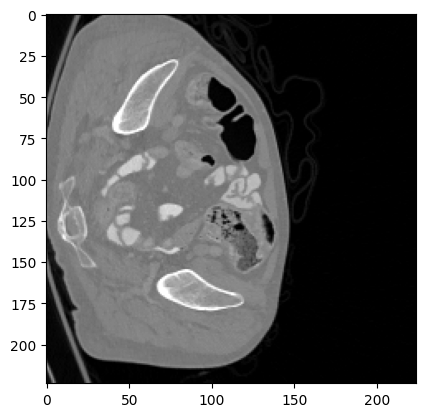

In [20]:
plt.imshow(img[0,0,:,:,50], cmap='gray');

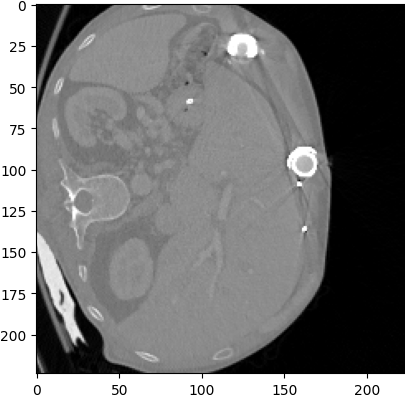

In [50]:
x = img[:,:,:,:,127]
#x = torch.from_numpy(ct_datasets.Resize(256)(x[0,0])[None,None])
plt.imshow(x[0][0].cpu().detach().numpy(), cmap='gray');

In [51]:
z = ae.encode(x.cuda())

In [52]:
img2 = ae.decode(z)

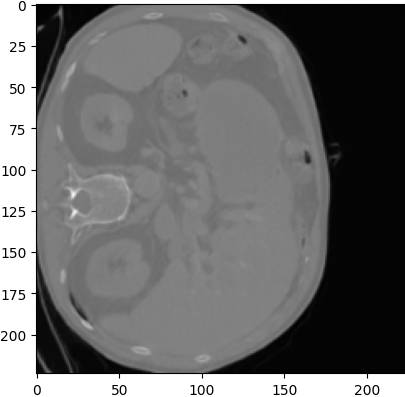

In [53]:
plt.imshow(img2[0][0].cpu().detach().numpy(), cmap='gray');

In [54]:
attr = captum.attr.LatentShift(
    latentshift.alignment.ModelWrapper(
        model, 
        target='Splenomegaly', 
        adjustment=lambda x: x+0.3,
        rename_model='', sigmoid=False), 
    ct_models.SliceAEFull(ae, 125,135),
)
output = attr.attribute(img.cuda(), target=0,
                        #fix_range=[-1600,0], 
                        return_dicts = True,
                        apply_sigmoid = False,
                        search_max_steps = 20000,
                       )[0]
#plt.imshow(output['heatmap'][0]);

Shift: 0, Pred: 0.7647686004638672, pixel_diff: 0.0, sum*diff_pct: 173698.609375
Shift: -10.0, Pred: 0.7155693769454956, pixel_diff: 96.65190887451172, sum*diff_pct: 173698.609375
Shift: -21.0, Pred: 0.7073595523834229, pixel_diff: 198.41763305664062, sum*diff_pct: 173698.609375
Shift: -34.0, Pred: 0.7009333372116089, pixel_diff: 316.68157958984375, sum*diff_pct: 173698.609375
Shift: -48.0, Pred: 0.6829802989959717, pixel_diff: 454.9243469238281, sum*diff_pct: 173698.609375
Shift: -63.0, Pred: 0.6823318600654602, pixel_diff: 1142.9705810546875, sum*diff_pct: 173698.609375
Shift: -80.0, Pred: 0.6911454200744629, pixel_diff: 2730.060791015625, sum*diff_pct: 173698.609375
Ending search: prediction stopped decreasing
Selected bounds:  -80.0 0
Lambdas to compute:  [-80.         -71.11111111 -62.22222222 -53.33333333 -44.44444444
 -35.55555556 -26.66666667 -17.77777778  -8.88888889   0.        ]


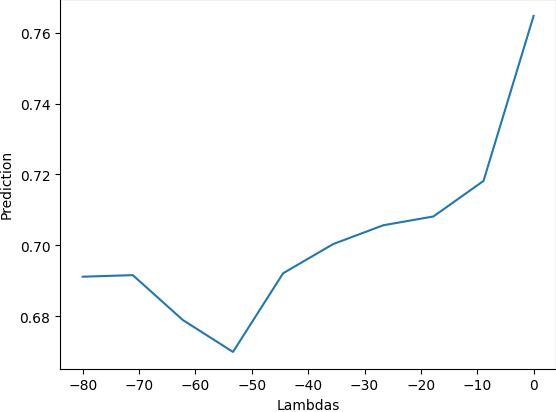

In [55]:
plt.plot(output['lambdas'],output['preds']);
plt.xlabel('Lambdas');
plt.ylabel('Prediction');

In [56]:
single_diffs = np.abs(output['heatmap']).sum(0).sum(0).sum(0)

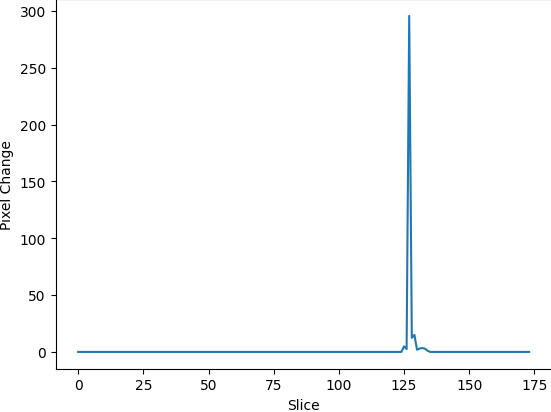

In [57]:
plt.plot(single_diffs);
plt.xlabel('Slice');
plt.ylabel('Pixel Change');

In [58]:
output['heatmap'].shape

(1, 224, 224, 174)

In [59]:
idx = output['heatmap'].sum(1).sum(1).argmax()
idx

127

In [70]:
idx =128

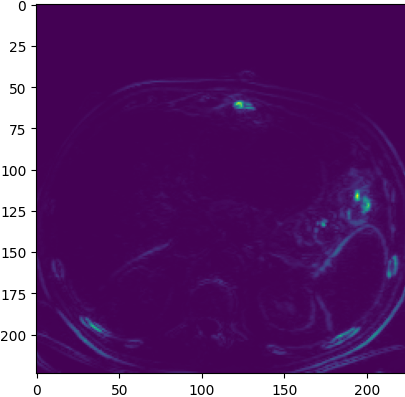

In [71]:
plt.imshow(skimage.transform.rotate(output['heatmap'][0,:,::-1,idx], -90));

In [77]:
images = [output['generated_images'][i, :,::-1,:,idx] for i in range(len(output['generated_images']))]
images = [skimage.transform.rotate(img[0],90)[None,...] for img in images]


In [78]:
images = [ct_datasets.window_level(img, -200, 400) for img in images]
#images = [ct_datasets.window_level(img, -20, 100) for img in images]

0.40234375 0.6953125
0.40234375 0.6953125
0.40234375 0.6953125
0.40234375 0.6953125
0.40234375 0.6953125
0.40234375 0.6953125
0.40234375 0.6953125
0.40234375 0.6953125
0.40234375 0.6953125
0.40234375 0.6953125


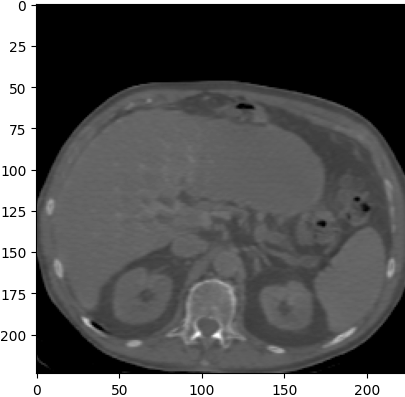

In [79]:
plt.imshow(images[0][0], cmap='gray');

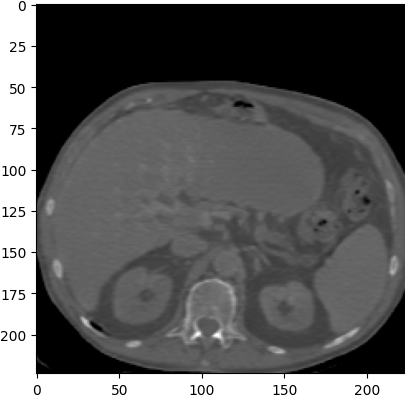

In [80]:
plt.imshow(images[-1][0], cmap='gray');

In [81]:
latentshift.video_utils.generate_video({'generated_images':images, 'preds':np.array(output['preds'])-(np.array(output['preds']).min())}, "test", show_pred=True, watermark=False, cmap='gray', 
                                       extra_loops=1,
                                      ffmpeg_path='/share/software/user/open/ffmpeg/5.0/bin/ffmpeg',
                                      resize=512)


/share/software/user/open/ffmpeg/5.0/bin/ffmpeg -loglevel quiet -stats -y -i /tmp/gifsplanation/image-%d.png -c:v libx264 -vf scale=-2:512 -profile:v baseline -level 3.0 -pix_fmt yuv420p 'test.mp4'
b''


frame=   40 fps=0.0 q=-1.0 Lsize=      29kB time=00:00:01.56 bitrate= 150.0kbits/s speed=6.56x    


In [82]:
latentshift.video_utils.write_frame(images[-1][0], 'Splenomegaly-base.png', cmap='gray', watermark=False)

In [83]:
latentshift.video_utils.write_frame(images[0][0], 'Splenomegaly-cf.png', cmap='gray', watermark=False)

In [84]:
latentshift.video_utils.write_frame(skimage.transform.rotate(output['heatmap'][0,:,::-1,idx], -90), 'Splenomegaly_heatmap.png', watermark=False)

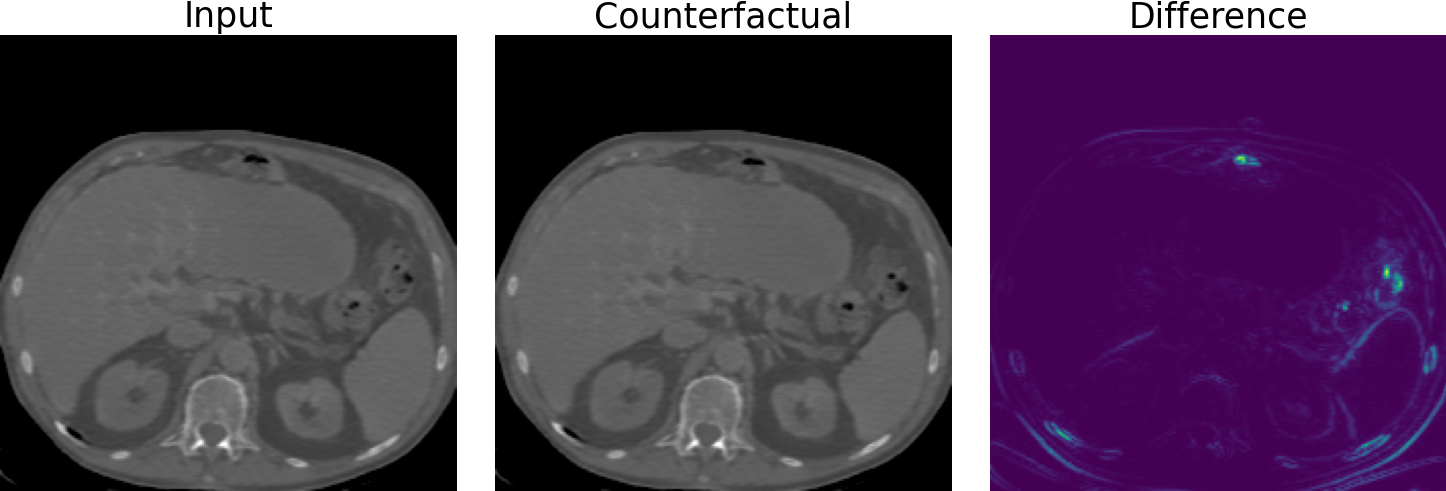

In [85]:
fig_image = images[-1][0]
fig_cf = images[0][0]
fig_heatmap = skimage.transform.rotate(output['heatmap'][0,:,::-1,idx], -90)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
axs[0].imshow(fig_image, cmap='gray')
axs[0].set_title('Input', size=25)
axs[1].imshow(fig_cf, cmap='gray')
axs[1].set_title('Counterfactual', size=25)
axs[2].imshow(fig_heatmap)
axs[2].set_title('Difference', size=25);
[axs[i].axis('off') for i in range(len(axs))]
plt.tight_layout()

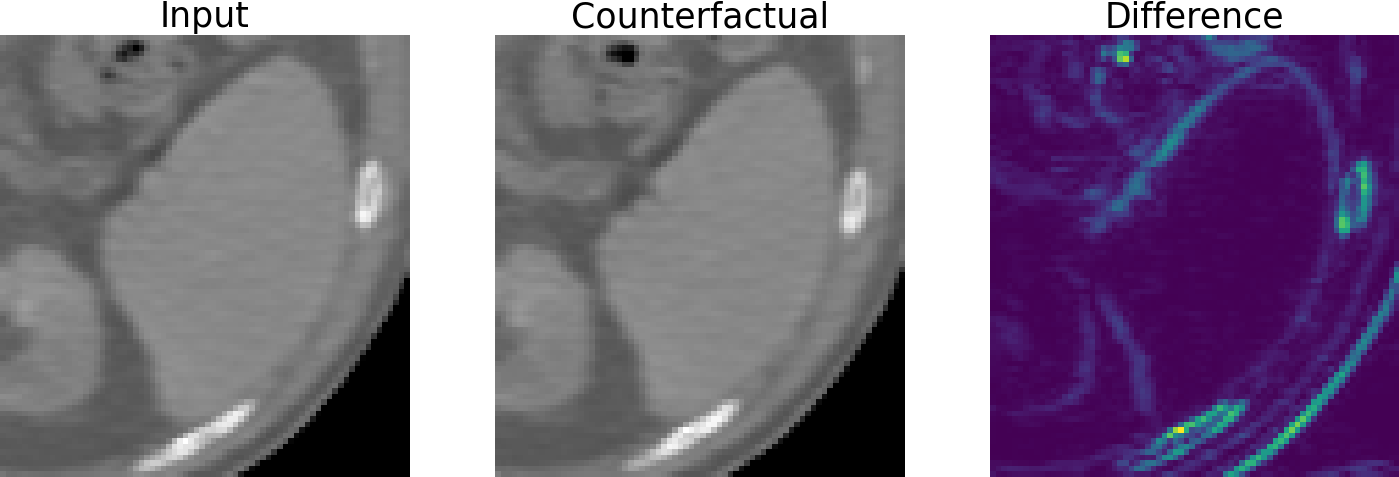

In [93]:
fig_image = images[-1][0]
fig_cf = images[0][0]
fig_heatmap = skimage.transform.rotate(output['heatmap'][0,:,::-1,idx], -90)

zoom_xy = 130,150
zoom_size = 80
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
axs[0].imshow(fig_image[zoom_xy[0]:zoom_xy[0]+zoom_size,zoom_xy[1]:zoom_xy[1]+zoom_size], cmap='gray')
axs[0].set_title('Input', size=25)
axs[1].imshow(fig_cf[zoom_xy[0]:zoom_xy[0]+zoom_size,zoom_xy[1]:zoom_xy[1]+zoom_size], cmap='gray')
axs[1].set_title('Counterfactual', size=25)
axs[2].imshow(fig_heatmap[zoom_xy[0]:zoom_xy[0]+zoom_size,zoom_xy[1]:zoom_xy[1]+zoom_size])
axs[2].set_title('Difference', size=25);
[axs[i].axis('off') for i in range(len(axs))]
plt.tight_layout()